# Computing the energy density of the Glasma in the MV model

In this notebook we compute the energy density of the Glasma in the MV model and compare the result to Tuomas Lappi's value from 2006 (see [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207)). By reproducing the same energy density we can be sure that our code works correctly. At $\tau_0 = 1.0 / g^2 \mu$ we obtain $\varepsilon(\tau_0) = 0.262 (g^2 \mu)^4 / g^2 $ which translates to $\varepsilon(\tau_0) = 136 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 2.0 \, \mathrm{GeV}$ and $\varepsilon(\tau_0) = 691 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 3.0 \, \mathrm{GeV}$. The numbers from [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207) are $130 \, \mathrm{GeV} / \mathrm{fm}^3$ and $700 \, \mathrm{GeV} / \mathrm{fm}^3$. Close enough.

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
from curraun.lyapunov import Lyapunov
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm
import copy

# define hbar * c in units of GeV * fm
hbarc = 0.197326 
print("\nHello, this cell is run!")


Using Numba
Using SU(2)
Using double precision
Using double precision
Using double precision

Hello, this cell is run!


In [2]:
def compute(p):    
    # output dictionary
    output = {}

    output["energy"], output["pL"] , output["pT"]  = [], [], []
    output["EL"], output["BL"], output["ET"], output["BT"] = [], [], [], []

    output["energyp"], output["pLp"] , output["pTp"]  = [], [], []
    output["ELp"], output["BLp"], output["ETp"], output["BTp"] = [], [], [], []

    output["ratio_dif"] = []
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    start_t = 1
    
    # event loop
    for e in range(p['NE']):
        #print("Simulating event {} of {}".format(e+1, p['NE']))            # Commented by Pooja
        print("\nSimulating event {} of {}".format(e+1, p['NE']))           # Added by Pooja


        # initialization
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)

        # initialize energy computation
        en = Energy(s)

        # copy of s
        sprime = copy.deepcopy(s)

        # ed for sprime
        enp = Energy(sprime)

        # initialize Lyapunov computation
        ly = Lyapunov(s, sprime)
        
        # change el field
        # peta1 = sprime.peta1.copy()
        # print('peta1_before', peta1[0, :])

        alpha = p["alpha"]
        
        m_noise = p["M_noise"]



       # print("Change el")
        ly.change_el(alpha)
        # ly.change_el(alpha, m_noise)


        # peta1 = sprime.peta1.copy()
        # print('peta1_after', peta1[0, :])

        # temporary results

        EL, BL, ET, BT = [], [], [], []
        ELp, BLp, ETp, BTp = [], [], [], []

        energy, pL, pT = [], [], []
        energyp, pLp, pTp = [], [], []

        ratio_dif_list = []

        taus = []

        if use_cuda:
            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))

        for t in tqdm(range(maxt)):
            core.evolve_leapfrog(s)

            # evole sprime copy of s with el changed
            core.evolve_leapfrog(sprime)

            if t >= start_t:
                # unit factors (GeV^2)
                units = E0 ** 2 / (s.g ** 2)

                # color factors (for quarks)
                Nc = core.su.NC
                f = 2 * s.g ** 2 / (2 * Nc)

                # Energy density calculation
                en.compute()

                # Energy density for sprime
                enp.compute()

                # unit factors (GeV^3)
                units = E0 ** 4
                EL.append(en.EL_mean * units)
                BL.append(en.BL_mean * units)
                ET.append(en.ET_mean * units)
                BT.append(en.BT_mean * units)

                ELp.append(enp.EL_mean * units)
                BLp.append(enp.BL_mean * units)
                ETp.append(enp.ET_mean * units)
                BTp.append(enp.BT_mean * units)

                # unit factors (Gev / fm^3)
                units = E0 ** 4 / hbarc ** 3
                energy.append(en.energy_density * units)

                pL.append(en.pL * units)
                pT.append(en.pT * units)

                energyp.append(enp.energy_density * units)

                pLp.append(enp.pL * units)
                pTp.append(enp.pT * units)

                ly.compute_change_el()
                ratio_dif_list.append(ly.ratio_dif)

                taus.append(t)

        energy = np.array(energy)
        energyp = np.array(energyp)

        EL, BL, ET, BT = np.array(EL), np.array(BL), np.array(ET), np.array(BT)
        ELp, BLp, ETp, BTp = np.array(ELp), np.array(BLp), np.array(ETp), np.array(BTp)

        pL, pT = np.array(pL), np.array(pT)
        pLp, pTp = np.array(pLp), np.array(pTp)

        ratio_dif_array = np.array(ratio_dif_list)

        output["energy"].append(energy)

        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)

        output["pL"].append(pL)
        output["pT"].append(pT)

        output["energyp"].append(energyp)

        output["ELp"].append(ELp)
        output["BLp"].append(BLp)
        output["ETp"].append(ETp)
        output["BTp"].append(BTp)

        output["pLp"].append(pLp)
        output["pTp"].append(pTp)
            
        output["ratio_dif"].append(ratio_dif_array)
    # perform average over events
    
    # also add standard deviations
    # output["energy_std"] = np.std(np.array(output["energy"]), axis=0)
    
    # output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    # output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    # output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    # output["BT_std"] = np.std(np.array(output["BT"]), axis=0)
    
    # output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    # output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    # compute means
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)

    output["energyp"] = np.mean(np.array(output["energyp"]), axis=0)
    
    output["ELp"] = np.mean(np.array(output["ELp"]), axis=0)
    output["BLp"] = np.mean(np.array(output["BLp"]), axis=0)
    output["ETp"] = np.mean(np.array(output["ETp"]), axis=0)
    output["BTp"] = np.mean(np.array(output["BTp"]), axis=0)
    
    output["pLp"] = np.mean(np.array(output["pLp"]), axis=0)
    output["pTp"] = np.mean(np.array(output["pTp"]), axis=0)

    output["ratio_dif"] = np.mean(np.array(output["ratio_dif"]), axis=0)
    
    # more useful stuff
    output["tau"] = np.array(taus) / np.max(taus) * p["TMAX"]
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

print("Hello, this cell is run!")



Hello, this cell is run!


In [4]:
# We compute everything for g^2 \mu = 1 GeV and then rescale the results.

g2mu = 1.0                     # [GeV]
RA = 67.7 / (g2mu / hbarc)     # Radius of the nucleus in [fm]
F = np.pi * RA ** 2            # Transverse area [fm^2]
L = np.sqrt(F)                 # Length of the simulation box [fm]
g = 2.0                        # Coupling constant
mu = g2mu / g ** 2             # MV model parameter [GeV]
m = 0.00001                    # No infrared regulation, except global charge neutrality

taumax = 1000.0                                                                                 # Pooja
tau_max = taumax/ g2mu * hbarc          # Maximum proper time    # 10.0 / g2mu * hbarc          # Pooja

m_noise = 0.001                                                                                   # Pooja


p_lappi = {    
    'L':    L,                 # transverse size [fm]

    'N':    32,                 # lattice size

    'DTS':  8,                # time steps per transverse spacing
    'TMAX': tau_max,           # max. proper time (tau) [fm/c]

    'G':    g,                 # YM coupling constant
    'MU':   mu,                # MV model parameter [GeV]
    'M':    m,                 # IR regulator [GeV]
    'UV':   100000.0,          # UV regulator [GeV]
    'NS':   1,                 # number of color sheets

    'NE':   1,                # number of events

    'alpha': 0.00001,

    'M_noise':   m_noise,           # Pooja
}




# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! POOJA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from datetime import datetime
present_time = datetime.now()               # datetime.now() gets the current date and time from your system. 
                                            # It returns a datetime object (which contains year, month, day, hour, minute, second, etc.).
                                            # Next, store that value in the variable present_time.
present_time_formatted = present_time.strftime("%d-%m-%Y %H:%M:%S")     # .strftime() means “string format time” 
                                                                        # It convertS a datetime object into a string, in your given format.
print("Hello, the time now is:   ", present_time_formatted, "\n")
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



from time import time
t1 = time()
r_lappi = compute(p_lappi)
t2 = time()
#print("{:3.2f} s".format(t2-t1))               # Commented by Pooja



# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++ Pooja ++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
r = r_lappi
tau = r["tau"] / hbarc

alpha = p_lappi["alpha"]
alpha2  = alpha**2.0   

L = p_lappi["L"]
N = p_lappi["N"]
a =L/N
N_events = p_lappi["NE"]

t_max = taumax

print("\n\nPARAMETERS USED:", "\n") 
print("No. of events =", N_events)       
print("alpha          =", alpha)                  
print("alpha squared  =", alpha2, "\n")  
print("Box_size,              L =", L)                  
print("No. of lattice points, N =", N)        
print("Lattice spacing,       a =", a, "\n")                  
         
print("Maximum time =", t_max) 
print("No. of events =", N_events, "\n")                  
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #






# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! POOJA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
present_time = datetime.now()
present_time_formatted = present_time.strftime("%d-%m-%Y %H:%M:%S") 
print("\n\nHello, the time now is:   ", present_time_formatted, "\n")

Elapsed_time = t2 - t1
print(f"Elapsed time: {Elapsed_time: 10.2f} seconds")                   # Added by Pooja

print("\nHello, this cell is run!")


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Hello, the time now is:    21-04-2025 18:47:51 


Simulating event 1 of 1


100%|██████████| 2128/2128 [00:01<00:00, 1249.69it/s]



PARAMETERS USED: 

No. of events = 1
alpha          = 1e-05
alpha squared  = 1.0000000000000002e-10 

Box_size,              L = 23.678158175122032
No. of lattice points, N = 32
Lattice spacing,       a = 0.7399424429725635 

Maximum time = 1000.0
No. of events = 1 



Hello, the time now is:    21-04-2025 18:47:53 

Elapsed time:       1.71 seconds

Hello, this cell is run!


In [5]:
import matplotlib.pyplot as plt

from matplotlib import rc
# rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

print("Hello, this cell is run!")


Hello, this cell is run!


No. of events = 1 

alpha          = 1e-05
alpha squared  = 1.0000000000000002e-10 

Box_size,              L = 23.678158175122032
No. of lattice points, N = 32
Lattice spacing,       a = 0.7399424429725635 

Maximum time = 1000.0


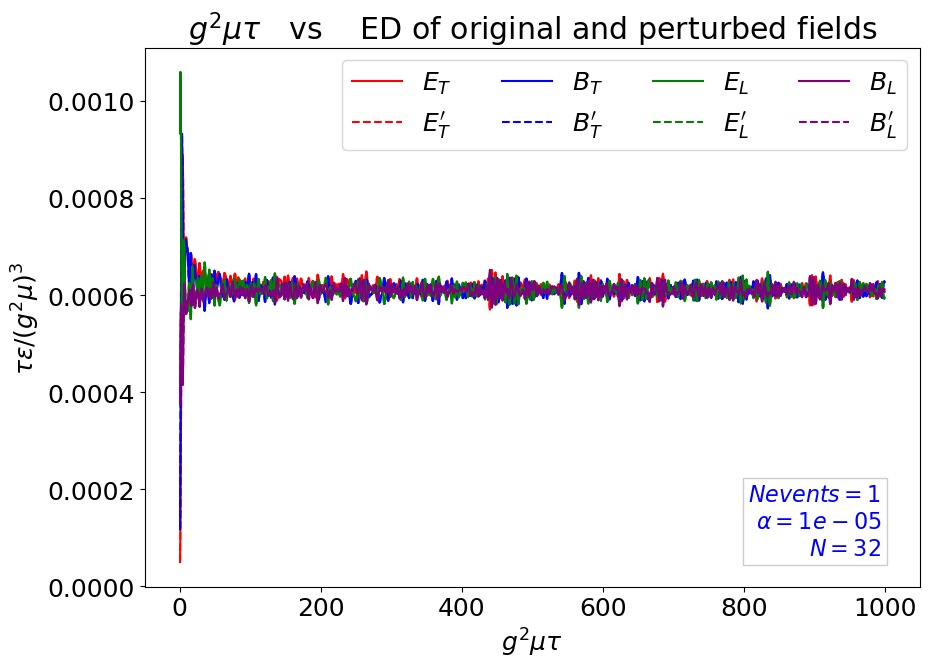

Hello, this cell is run!


In [7]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++ Pooja ++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
print("No. of events =", N_events, "\n")             

print("alpha          =", alpha)                  
print("alpha squared  =", alpha2, "\n")  
print("Box_size,              L =", L)                  
print("No. of lattice points, N =", N)        
print("Lattice spacing,       a =", a, "\n")                  
         
print("Maximum time =", t_max)                  
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #





# plt.errorbar(tau, r["ET"], yerr=r["ET_std"], errorevery=100, label="ET")
# plt.errorbar(tau, r["BT"], yerr=r["BT_std"], errorevery=100, label="BT")
# plt.errorbar(tau, r["EL"], yerr=r["EL_std"], errorevery=100, label="EL")
# plt.errorbar(tau, r["BL"], yerr=r["BL_std"], errorevery=100, label="BL")

colors = ['red', 'blue', 'green', 'purple']

plt.plot(tau, r["ET"], label=r"$E_T$", color=colors[0])
plt.plot(tau, r["ETp"], label=r"$E_T^{\prime}$", linestyle="dashed", color=colors[0])

plt.plot(tau, r["BT"], label=r"$B_T$", color=colors[1])
plt.plot(tau, r["BTp"], label=r"$B_T^{\prime}$", linestyle="dashed", color=colors[1])

plt.plot(tau, r["EL"], label=r"$E_L$", color=colors[2])
plt.plot(tau, r["ELp"], label=r"$E_L^{\prime}$", linestyle="dashed", color=colors[2])

plt.plot(tau, r["BL"], label=r"$B_L$", color=colors[3])
plt.plot(tau, r["BLp"], label=r"$B_L^{\prime}$", linestyle="dashed", color=colors[3])


plt.title(r"$g^2 \mu \tau$   vs    ED of original and perturbed fields")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\tau \varepsilon / (g^2 \mu)^3$")


# Construct the LaTeX string using f-strings # Add the text to the plot
text = rf"$Nevents = {N_events}$" + "\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$N = {N}$" 
plt.text(0.95, 0.05, text, color="blue", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')

#plt.text(400, 0.0001, f"N = {N}", fontsize=12, bbox=dict(facecolor='gray', alpha=0.2))               # Add text inside a box         
#plt.text(400, 0.0001, text, color="blue", fontsize=16)


plt.legend(ncols=4)


plt.savefig('plot_tau_EnergyDensities.png', dpi=600)
plt.show()

print("Hello, this cell is run!")



No. of events = 1 

alpha          = 1e-05
alpha squared  = 1.0000000000000002e-10 

Box_size,              L = 23.678158175122032
No. of lattice points, N = 32
Lattice spacing,       a = 0.7399424429725635 

Maximum time = 1000.0


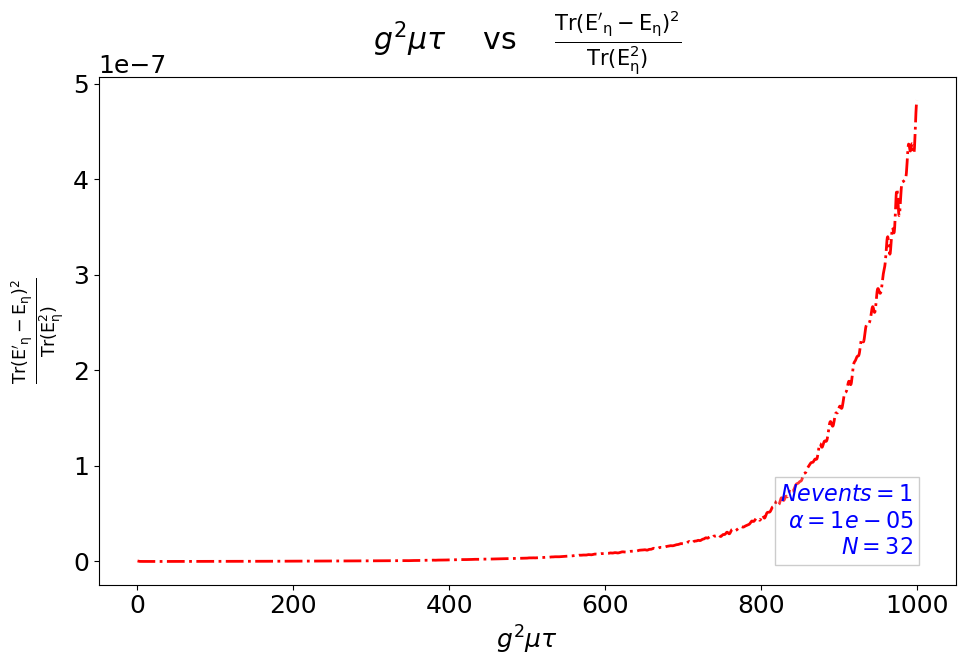

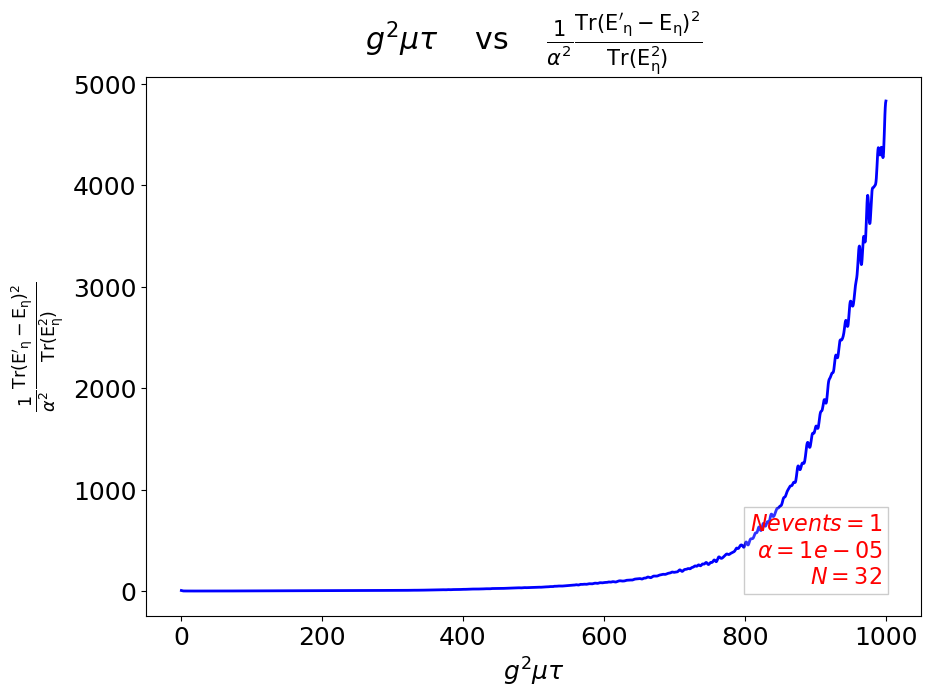

Hello, this cell is run!


In [8]:
# This whole cell is writteb by Pooja

print("No. of events =", N_events, "\n")        
print("alpha          =", alpha)                  
print("alpha squared  =", alpha2, "\n")  
print("Box_size,              L =", L)                  
print("No. of lattice points, N =", N)        
print("Lattice spacing,       a =", a, "\n")                  
print("Maximum time =", t_max) 

# plt.plot(tau, np.ones(len(tau)), color='gray')

# ====================================================================================================================================== #
# ====================================================================================================================================== #
# Plotting and saving (plot and data) for x for time vs Ratio_differece_Eta

x = tau                                                      
y = r["ratio_dif"]                                        
plt.plot(x, y, color='red', linestyle="dashdot", linewidth=2.0) 

plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                              # To change the x scale          
#plt.ylim(0.0, 0.00001)                                                                                        # To change the y scale          


plt.text(0.95, 0.05, text, color="blue", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')


plt.tight_layout()                                                                                      # Pooja: Automatically adjusts the layout to prevent cutting
plt.savefig('plot_tau_diffEeta.png', dpi=600)
plt.show()

# Save Data into csv file:
import pandas as pd
df = pd.DataFrame({"tau": x, " diff_Eeta": y})                   # Assuming x and y are lists or NumPy arrays
df.to_csv("data_tau_diffEeta.csv", index=False)
# ====================================================================================================================================== #
# ====================================================================================================================================== #




# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# Plotting and saving (plot and data) for x for time vs Ratio_differece_Eta by alpha_squared

x = tau                                                                        
y = r["ratio_dif"]/alpha2                                            
plt.plot(x, y, color='blue', linestyle="solid", linewidth=2.0)    

plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                        # To change the x scale       
#Splt.ylim(0.0, 0.1)                                                                                        # To change the scale          

plt.text(0.95, 0.05, text, color="red", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')


plt.savefig('plot_tau_diffEeta_alpha2.png', dpi=600)
plt.show()

# Save Data into csv file:
#import pandas as pd
df = pd.DataFrame({"tau": x, "diffEeta_alpha2": y})           # Assuming x and y are lists or NumPy arrays
df.to_csv("data_tau_diffEeta_alpha2.csv", index=False)
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

print("Hello, this cell is run!")
